# Impact of Governmental Investment Policies in Science and Technology through the Synthetic Diff in Diff

<table align="inner">
  <td>
    <a href="https://github.com/rod53/BrScienceSDID/blob/main/IGERDBR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>

## 1 SETUP
Check that Python 3.5 or later is installed, as well as Scikit-Learn ≥0.20. Import the libraries for the analysis. Ensure MatplotLib plots figures inline and prepare a function to save the figures. Set where to save the figures.

In [1]:
import sys
assert sys.version_info >= (3, 5) # Python ≥3.5 is required
import sklearn
assert sklearn.__version__ >= "0.20"# Scikit-Learn ≥0.20 is required
import numpy as np
import os
import tarfile
import urllib.request
import pandas as pd
import pycountry
import pycountry_convert as pc
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from toolz import curry, partial
import seaborn as sns
from matplotlib import pyplot as plt
import cvxpy as cp

# To ignore some boring warnings
import warnings
warnings.filterwarnings('ignore')

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from matplotlib import style
style.use("ggplot")
pd.set_option('display.max_columns', 60)

## 2 GET THE DATA
The datasets used in this study were collected from four different databases, which are described in the following sections. 

_(Note to Prof. Brei: so far have coded only two of the four databases. The other two are SCImago Database (from Elsevier/Scopus) and the World Intelectual Property Organization (WIPO). Both databases extraction are in the process of being coded.)_

### 2.1 Sistema Integrado de Planejamento e Orçamento (SIOP)
Data collected from Sistema Integrado de Planejamento e Orçamento (SIOP) from the Brazilian Ministry of Economy (ME) and the Brazilian Ministry of Science, Technology, Innovation and Communication (MCTIC). The SIOP is the main tool for the formulation and monitoring of the Brazilian public budget. The data are available in the SIOP website (https://siop.mec.gov.br/). The data were collected from 2000 to 2020.

In [2]:
# #Import data from github for each dataset in SIOP
# CAPESurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/SIOP/CAPES.csv"
# CAPESdf = pd.read_csv(CAPESurl, sep=";", encoding="utf-8")

# CNPQurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/SIOP/CNPq.csv"
# CNPQdf = pd.read_csv(CNPQurl, sep=";", encoding="utf-8")

# FNDCTurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/SIOP/FNDCT.csv"
# FNDCTdf = pd.read_csv(FNDCTurl, sep=";", encoding="utf-8")
# # Leave only the columns of interest
# CAPESdf = CAPESdf[['Ano', 'Função', 'Projeto de Lei', 'Dotação Inicial', 'Dotação Atual', 'Empenhado', 'Liquidado', 'Pago']]
# # Eliminate the rows with the total of the 
# CAPESdf = CAPESdf[CAPESdf['Ano'] != 'Total']
# # # Replace "." for "," in whole dataframe
# # CAPESdf = CAPESdf.replace('.', '', regex=True)

# # Sum total per year
# CAPESdf = CAPESdf.groupby(['Ano']).sum()

# # Convert the columns to numeric
# CAPESdf['Projeto de Lei'] = pd.to_numeric(CAPESdf['Projeto de Lei'], errors='coerce')
# CAPESdf['Dotação Inicial'] = pd.to_numeric(CAPESdf['Dotação Inicial'], errors='coerce')
# CAPESdf['Dotação Atual'] = pd.to_numeric(CAPESdf['Dotação Atual'], errors='coerce')
# CAPESdf['Empenhado'] = pd.to_numeric(CAPESdf['Empenhado'], errors='coerce')
# CAPESdf['Liquidado'] = pd.to_numeric(CAPESdf['Liquidado'], errors='coerce')
# CAPESdf['Pago'] = pd.to_numeric(CAPESdf['Pago'], errors='coerce')



### 2.2 UNESCO Institute of Statistics (UIS)
Free and open access to global demographic, socio-economical data, used as covariate in the SCM ans SDID. Available in http://data.uis.unesco.org/.

In [3]:
#Import data from github for each dataset in UIS
APOPurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/APOP.csv"
APOPdf = pd.read_csv(APOPurl, sep=";", encoding="latin-1")
GDPurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/GDP.csv"
GDPdf = pd.read_csv(GDPurl, sep=";", encoding="latin-1")
GDPPCurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/GDPPC.csv"
GDPPCdf = pd.read_csv(GDPPCurl, sep=";", encoding="latin-1")
GETEurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/GETE.csv"
GETEdf = pd.read_csv(GETEurl, sep=";", encoding="latin-1")
GERDurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/GERD.csv"
GERDdf = pd.read_csv(GERDurl, sep=";", encoding="latin-1")
RPMIurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/UIS/RPMI.csv"
RPMIdf = pd.read_csv(RPMIurl, sep=";", encoding="latin-1")

# The datasets include other variables on the same file, this code aims to leave only the desired rows
APOPdf = APOPdf[APOPdf['Indicator'] == "Population aged 25-64 years (thousands) "]
GDPdf = GDPdf[GDPdf['Indicator'] == "GDP, PPP (constant 2011 international $)"]
GDPPCdf = GDPPCdf[GDPPCdf['Indicator'] == "GDP per capita, PPP (constant 2011 international $)"]
GETEdf = GETEdf[GETEdf['Indicator'] == "Government expenditure on tertiary education as a percentage of GDP (%)"]
GERDdf = GERDdf[GERDdf['Indicator'] == "GERD as a percentage of GDP"]
RPMIdf = RPMIdf[RPMIdf['Indicator'] == "Researchers per million inhabitants (FTE)"]

# Sort by Code and Year
APOPdf.sort_values(by=['Code', 'Year'], inplace=True)
GDPdf.sort_values(by=['Code', 'Year'], inplace=True)
GDPPCdf.sort_values(by=['Code', 'Year'], inplace=True)
GETEdf.sort_values(by=['Code', 'Year'], inplace=True)
GERDdf.sort_values(by=['Code', 'Year'], inplace=True)
RPMIdf.sort_values(by=['Code', 'Year'], inplace=True)

# Leave only the columns of interest
APOPdf = APOPdf[['Code', 'Year', 'Value']]
GDPdf = GDPdf[['Code', 'Year', 'Value']]
GDPPCdf = GDPPCdf[['Code', 'Year', 'Value']]
GETEdf = GETEdf[['Code', 'Year', 'Value']]
GERDdf = GERDdf[['Code', 'Year', 'Value']]
RPMIdf = RPMIdf[['Code', 'Year', 'Value']]

# Rename the columns with name of the indicator
APOPdf.rename(columns={'Value': 'APOP'}, inplace=True)
GDPdf.rename(columns={'Value': 'GDP'}, inplace=True)
GDPPCdf.rename(columns={'Value': 'GDPPC'}, inplace=True)
GETEdf.rename(columns={'Value': 'GETE'}, inplace=True)
GERDdf.rename(columns={'Value': 'GERD'}, inplace=True)
RPMIdf.rename(columns={'Value': 'RPMI'}, inplace=True)

# sum how many countries appear 22 times in each dataframe
print((APOPdf['Code'].value_counts() == 22).value_counts())
print((GDPdf['Code'].value_counts() == 22).value_counts())
print((GDPPCdf['Code'].value_counts() == 22).value_counts())
print((GETEdf['Code'].value_counts() == 10).value_counts()) # This dataset will be removed for excessive missing data
print((GERDdf['Code'].value_counts() == 10).value_counts()) # This dataset will be removed for excessive missing data
print((RPMIdf['Code'].value_counts() == 10).value_counts()) # This dataset will be removed for excessive missing data

True     213
False     17
Name: Code, dtype: int64
True     172
False     21
Name: Code, dtype: int64
True     172
False     21
Name: Code, dtype: int64
False    177
True       7
Name: Code, dtype: int64
False    180
True       4
Name: Code, dtype: int64
False    173
True       2
Name: Code, dtype: int64


### 2.3 InCites - Clarivates (IC)
InCites is a paid-access platform from Clarivates, the same group as the Web of Science (WoS), that provides access to multiple databases of reference and citation data from academic journals, conference proceedings, and other documents in various academic disciplines. Available on https://incites.clarivate.com/.

In [4]:
#Import data from github for each dataset in IC
IC2000url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2000IncitesLocations.csv"
IC2000df = pd.read_csv(IC2000url, sep=";", encoding="latin-1")
IC2001url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2001IncitesLocations.csv"
IC2001df = pd.read_csv(IC2001url, sep=";", encoding="latin-1")
IC2002url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2002IncitesLocations.csv"
IC2002df = pd.read_csv(IC2002url, sep=",", encoding="latin-1")
IC2003url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2003IncitesLocations.csv"
IC2003df = pd.read_csv(IC2003url, sep=",", encoding="latin-1")
IC2004url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2004IncitesLocations.csv"
IC2004df = pd.read_csv(IC2004url, sep=",", encoding="latin-1")
IC2005url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2005IncitesLocations.csv"
IC2005df = pd.read_csv(IC2005url, sep=",", encoding="latin-1")
IC2006url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2006IncitesLocations.csv"
IC2006df = pd.read_csv(IC2006url, sep=",", encoding="latin-1")
IC2007url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2007IncitesLocations.csv"
IC2007df = pd.read_csv(IC2007url, sep=",", encoding="latin-1")
IC2008url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2008IncitesLocations.csv"
IC2008df = pd.read_csv(IC2008url, sep=",", encoding="latin-1")
IC2009url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2009IncitesLocations.csv"
IC2009df = pd.read_csv(IC2009url, sep=",", encoding="latin-1")
IC2010url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2010IncitesLocations.csv"
IC2010df = pd.read_csv(IC2010url, sep=",", encoding="latin-1")
IC2011url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2011IncitesLocations.csv"
IC2011df = pd.read_csv(IC2011url, sep=",", encoding="latin-1")
IC2012url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2012IncitesLocations.csv"
IC2012df = pd.read_csv(IC2012url, sep=",", encoding="latin-1")
IC2013url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2013IncitesLocations.csv"
IC2013df = pd.read_csv(IC2013url, sep=",", encoding="latin-1")
IC2014url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2014IncitesLocations.csv"
IC2014df = pd.read_csv(IC2014url, sep=",", encoding="latin-1")
IC2015url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2015IncitesLocations.csv"
IC2015df = pd.read_csv(IC2015url, sep=",", encoding="latin-1")
IC2016url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2016IncitesLocations.csv"
IC2016df = pd.read_csv(IC2016url, sep=",", encoding="latin-1")
IC2017url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2017IncitesLocations.csv"
IC2017df = pd.read_csv(IC2017url, sep=",", encoding="latin-1")
IC2018url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2018IncitesLocations.csv"
IC2018df = pd.read_csv(IC2018url, sep=",", encoding="latin-1")
IC2019url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2019IncitesLocations.csv"
IC2019df = pd.read_csv(IC2019url, sep=",", encoding="latin-1")
IC2020url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2020IncitesLocations.csv"
IC2020df = pd.read_csv(IC2020url, sep=",", encoding="latin-1")
IC2021url = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/IC/2021IncitesLocations.csv"
IC2021df = pd.read_csv(IC2021url, sep=",", encoding="latin-1")

# Add a new line in the beginning of each dataset with the year
IC2000df.insert(0, 'Year', '2000')
IC2001df.insert(0, 'Year', '2001')
IC2002df.insert(0, 'Year', '2002')
IC2003df.insert(0, 'Year', '2003')
IC2004df.insert(0, 'Year', '2004')
IC2005df.insert(0, 'Year', '2005')
IC2006df.insert(0, 'Year', '2006')
IC2007df.insert(0, 'Year', '2007')
IC2008df.insert(0, 'Year', '2008')
IC2009df.insert(0, 'Year', '2009')
IC2010df.insert(0, 'Year', '2010')
IC2011df.insert(0, 'Year', '2011')
IC2012df.insert(0, 'Year', '2012')
IC2013df.insert(0, 'Year', '2013')
IC2014df.insert(0, 'Year', '2014')
IC2015df.insert(0, 'Year', '2015')
IC2016df.insert(0, 'Year', '2016')
IC2017df.insert(0, 'Year', '2017')
IC2018df.insert(0, 'Year', '2018')
IC2019df.insert(0, 'Year', '2019')
IC2020df.insert(0, 'Year', '2020')
IC2021df.insert(0, 'Year', '2021')

# Rename the second column to "Name"
IC2000df.rename(columns={IC2000df.columns[1]: "Name"}, inplace=True)
IC2001df.rename(columns={IC2001df.columns[1]: "Name"}, inplace=True)
IC2002df.rename(columns={IC2002df.columns[1]: "Name"}, inplace=True)
IC2003df.rename(columns={IC2003df.columns[1]: "Name"}, inplace=True)
IC2004df.rename(columns={IC2004df.columns[1]: "Name"}, inplace=True)
IC2005df.rename(columns={IC2005df.columns[1]: "Name"}, inplace=True)
IC2006df.rename(columns={IC2006df.columns[1]: "Name"}, inplace=True)
IC2007df.rename(columns={IC2007df.columns[1]: "Name"}, inplace=True)
IC2008df.rename(columns={IC2008df.columns[1]: "Name"}, inplace=True)
IC2009df.rename(columns={IC2009df.columns[1]: "Name"}, inplace=True)
IC2010df.rename(columns={IC2010df.columns[1]: "Name"}, inplace=True)
IC2011df.rename(columns={IC2011df.columns[1]: "Name"}, inplace=True)
IC2012df.rename(columns={IC2012df.columns[1]: "Name"}, inplace=True)
IC2013df.rename(columns={IC2013df.columns[1]: "Name"}, inplace=True)
IC2014df.rename(columns={IC2014df.columns[1]: "Name"}, inplace=True)
IC2015df.rename(columns={IC2015df.columns[1]: "Name"}, inplace=True)
IC2016df.rename(columns={IC2016df.columns[1]: "Name"}, inplace=True)
IC2017df.rename(columns={IC2017df.columns[1]: "Name"}, inplace=True)
IC2018df.rename(columns={IC2018df.columns[1]: "Name"}, inplace=True)
IC2019df.rename(columns={IC2019df.columns[1]: "Name"}, inplace=True)
IC2020df.rename(columns={IC2020df.columns[1]: "Name"}, inplace=True)
IC2021df.rename(columns={IC2021df.columns[1]: "Name"}, inplace=True)

# Import csv from https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/CountryCode.csv
CODEurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/CountryCode.csv"
CODEdf = pd.read_csv(CODEurl, sep=";", encoding="latin-1")
CODEdf.head()

# Create a new column with the country code
IC2000df['Code'] = IC2000df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2001df['Code'] = IC2001df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2002df['Code'] = IC2002df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2003df['Code'] = IC2003df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2004df['Code'] = IC2004df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2005df['Code'] = IC2005df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2006df['Code'] = IC2006df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2007df['Code'] = IC2007df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2008df['Code'] = IC2008df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2009df['Code'] = IC2009df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2010df['Code'] = IC2010df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2011df['Code'] = IC2011df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2012df['Code'] = IC2012df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2013df['Code'] = IC2013df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2014df['Code'] = IC2014df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2015df['Code'] = IC2015df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2016df['Code'] = IC2016df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2017df['Code'] = IC2017df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2018df['Code'] = IC2018df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2019df['Code'] = IC2019df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2020df['Code'] = IC2020df['Name'].map(CODEdf.set_index('Name')['Code'])
IC2021df['Code'] = IC2021df['Name'].map(CODEdf.set_index('Name')['Code'])
# Merge all dataframes
ICdf = pd.concat([IC2000df, IC2001df, IC2002df, IC2003df, IC2004df, IC2005df, IC2006df, IC2007df, IC2008df, IC2009df, IC2010df, IC2011df, IC2012df, IC2013df, IC2014df, IC2015df, IC2016df, IC2017df, IC2018df, IC2019df, IC2020df, IC2021df], ignore_index=True)
ICdf['Year']=ICdf['Year'].astype(int) # Convert year to integer, to be able to merge to other tables

# Convert Web of Science to numeric 
ICdf['Web of Science Documents'] = pd.to_numeric(ICdf['Web of Science Documents'], errors='coerce')

ICdf.head()

,Year,Name,Web of Science Documents,Times Cited,Rank,% Docs Cited,Category Normalized Citation Impact,International Collaborations,All Open Access Documents,% First Author (2008-2022),% Global Baseline (Docs),% Documents in Top 1%,% International Collaborations,Gold Documents,% Last Author (2008-2022),% Global Baseline (Cites),Citation Impact,% Documents in Top 10%,% Industry Collaborations,Gold - Hybrid Documents,% Corresponding Author (2008-2022),% Baseline for All Items (Docs),Average Percentile,% Highly Cited Papers,Location Type,Free to Read Documents,First Author (2008-2022),Industry Collaborations,% Baseline for All Items (Cites),Highly Cited Papers,...,Green Accepted Documents,Corresponding Author (2008-2022),% Domestic Collaborations,% Baseline for Pinned Items (Cites),Documents in JIF Journals,Green Published Documents,Documents in Q1 Journals,Green Only Documents,Citations From Patents,Documents in Q2 Journals,Non-Open Access Documents,Documents in Q3 Journals,% All Open Access Documents,Documents in Q4 Journals,% Gold Documents,% Documents in Q1 Journals,% Gold - Hybrid Documents,% Documents in Q2 Journals,% Free to Read Documents,% Documents in Q3 Journals,% Green Submitted Documents,% Documents in Q4 Journals,% Green Accepted Documents,% Green Published Documents,Documents in Top 1%,Documents in Top 10%,% Green Only Documents,Hot Papers,% Non-Open Access Documents,Code
0,2000,Global Baseline,1348891.0,35800053.0,NaN,65.84,0.986064,147694.0,152555.0,NaN,100.000000,1.20,10.95,8126.0,NaN,100.000000,26.540360,9.82,1.86,9844.0,NaN,NaN,38.580154,0.0,NaN,79841.0,NaN,25060.0,NaN,0.0,...,4273.0,NaN,17.48,NaN,1009815.0,44237.0,478311.0,54744.0,620620.0,227558.0,1196336.0,161771.0,11.31,142175.0,0.60,47.37,0.73,22.53,5.92,16.02,2.91,14.08,0.32,3.28,16204.0,132442.0,4.06,0.0,88.69,NaN
1,2000,Baseline for All Items,1168409.0,35591771.0,NaN,73.65,1.050718,147694.0,148532.0,NaN,NaN,1.29,12.64,7844.0,NaN,NaN,30.461740,10.76,2.14,9793.0,NaN,100.000000,42.872130,0.0,NaN,76917.0,NaN,25060.0,100.000000,0.0,...,4214.0,NaN,20.19,NaN,903930.0,43532.0,444541.0,53978.0,616981.0,209464.0,1019877.0,144423.0,12.71,105502.0,0.67,49.18,0.84,23.17,6.58,15.98,3.32,11.67,0.36,3.73,15048.0,125778.0,4.62,0.0,87.29,NaN
2,2000,USA,435823.0,17265962.0,1.0,70.54,1.353955,67767.0,60026.0,0.0,32.309727,1.91,15.55,1757.0,0.0,48.228873,39.616913,14.08,2.96,5399.0,0.0,37.300551,45.125284,0.0,Country/Region,29755.0,0.0,12912.0,48.511107,0.0,...,1862.0,0.0,20.30,NaN,338466.0,18744.0,205182.0,23115.0,333591.0,67682.0,375797.0,42064.0,13.77,23538.0,0.40,60.62,1.24,20.00,6.83,12.43,3.46,6.95,0.43,4.30,8319.0,61385.0,5.30,0.0,86.23,USA
3,2000,UNITED KINGDOM,116683.0,4239808.0,2.0,72.80,1.227118,28657.0,18903.0,0.0,8.650291,1.63,24.56,410.0,0.0,11.843022,36.336124,12.57,2.68,818.0,0.0,9.986486,45.165139,0.0,Country/Region,11194.0,0.0,3124.0,11.912327,0.0,...,1167.0,0.0,13.64,NaN,93146.0,6935.0,50203.0,6481.0,58416.0,23683.0,97780.0,12252.0,16.20,7008.0,0.35,53.90,0.70,25.43,9.59,13.15,3.60,7.52,1.00,5.94,1898.0,14668.0,5.55,0.0,83.80,GBR
4,2000,ENGLAND,99285.0,3682421.0,3.0,72.97,1.242332,24519.0,16312.0,0.0,7.360491,1.66,24.70,349.0,0.0,10.286077,37.089399,12.82,2.94,694.0,0.0,8.497453,45.458981,0.0,Country/Region,9640.0,0.0,2919.0,10.346271,0.0,...,962.0,0.0,14.58,NaN,79594.0,6059.0,43225.0,5629.0,51543.0,20113.0,82973.0,10315.0,16.43,5941.0,0.35,54.31,0.70,25.27,9.71,12.96,3.71,7.46,0.97,6.10,1648.0,12727.0,5.67,0.0,83.57,NaN


## 3 CONSOLIDATE DATA
This section aims to consolidate the data from the different sources, in order to create a single dataset with all the information needed for the analysis.

In [5]:
# Import ID to be used to find the Codes for IC data
IDurl = "https://raw.githubusercontent.com/rod53/BrScienceSDID/main/data/ID.csv"
IDdf = pd.read_csv(IDurl, sep=";", encoding="latin-1")
#rename the first column to "Name"
IDdf.rename(columns={IDdf.columns[0]: "Name"}, inplace=True)
# Leave only one name for each country
IDdf.drop(IDdf.columns[[1,2,3]], axis=1, inplace=True)
IDdf.head()

# Create a list of countries to be used in the analysis
DB = IDdf.copy()
DB['Year'] = [2000]*213
for i in range(2001, 2022):
    DBappend = IDdf.copy()
    DBappend['Year'] = [i]*213
    DB = DB.append(DBappend, ignore_index=True)

#Join all datasets in one
df = pd.merge(DB, APOPdf, on=['Code', 'Year'], how='outer', suffixes= ('', '_y'))
df = pd.merge(df, GDPdf, on=['Code', 'Year'], how='outer')
df = pd.merge(df, GDPPCdf, on=['Code', 'Year'], how='outer')
df = pd.merge(df, GETEdf, on=['Code', 'Year'], how='outer')
df = pd.merge(df, GERDdf, on=['Code', 'Year'], how='outer')
df = pd.merge(df, RPMIdf, on=['Code', 'Year'], how='outer')
df = pd.merge(df, ICdf, on=['Code', 'Year'], how='outer')

#Sort by Code and Year
df.sort_values(by=['Code', 'Year'], inplace=True)

# Rename column "Name_x" to "Country"
df.rename(columns={'Name_x': 'Country'}, inplace=True)

# Drop coloumn "Name_y"
df.drop('Name_y', axis=1, inplace=True)

# Drop coloumn "Location Type"
df.drop('Location Type', axis=1, inplace=True)

# Drop columns which the label start with "%"
df = df.loc[:, ~df.columns.str.startswith('%')]

#Drop rows with missing values in Country
df.dropna(subset=['Country'], inplace=True)



## 4 FIRST LOOK AT THE 
This section aims to get a first look at the data, in order to understand the structure of the dataset and the variables that will be used in the analysis.

In [6]:
# Count how many countries show up in df
print(df['Country'].nunique())

# General information about the dataset
df.info()

# Create a table with the % of missing values for each column
df.isnull().sum()/len(df)*100

213
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4686 entries, 9 to 4685
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              4686 non-null   object 
 1   Code                                 4686 non-null   object 
 2   Region                               4642 non-null   object 
 3   Income Group                         4642 non-null   object 
 4   Year                                 4686 non-null   int64  
 5   APOP                                 4510 non-null   float64
 6   GDP                                  4168 non-null   float64
 7   GDPPC                                4168 non-null   float64
 8   GETE                                 1815 non-null   float64
 9   GERD                                 1891 non-null   float64
 10  RPMI                                 1492 non-null   float64
 11  Web of Science Documents  

Country                                 0.000000
Code                                    0.000000
Region                                  0.938967
Income Group                            0.938967
Year                                    0.000000
APOP                                    3.755869
GDP                                    11.054204
GDPPC                                  11.054204
GETE                                   61.267606
GERD                                   59.645753
RPMI                                   68.160478
Web of Science Documents                8.557405
Times Cited                             8.557405
Rank                                    8.557405
Category Normalized Citation Impact     8.557405
International Collaborations            8.557405
All Open Access Documents               8.557405
Gold Documents                          8.557405
Citation Impact                         8.557405
Gold - Hybrid Documents                 8.557405
Average Percentile  

## 5 CLEANING MISSING DATA

This section aims to clean the data, in order to remove the missing values.

The approach used is to remove the missing values was the interpolation of the missing values with the mean of the values of the adjacent years. The interpolation with the mean of the values of the adjacent years is a good approximation of the value of the year in question.

_(Note to Prof. Brei: Regarding the outliers, I will not remove them, because they may contribute to the analysis. Both SCM and SDID are tolerant to atypical values.)_

In [7]:
# Interpolate missing values for each Country, using values from previous and next years
df['APOP'] = df.groupby('Country')['APOP'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))

# Drop rows with missing values in the columns APOP, GDP or Web of Science Documents
df = df.dropna(subset=['APOP', 'GDP', 'Web of Science Documents'])
# Count how many countries show up in df, after dropping rows with missing values
print(df['Country'].nunique())

# Column names adjustment, substituting spaces with underscores
df.columns = df.columns.str.replace(' ', '_')

# Create a table with the % of missing values for each column
df.isnull().sum()/len(df)*100
# Drop countries with less than 22 observations
df = df.groupby('Country').filter(lambda x: len(x) > 21)

185


## 6 DISCOVER AND VISUALIZE THE DATA TO GAIN INSIGHTS
The main objective of this sections is to understand the data and to identify its main characteristics. 

In [8]:
# Count how many countries show up in df, after dropping rows with missing values
print(df['Country'].nunique())

# General information about the dataset
df.info()

# Create a table with the % of missing values for each column
df.isnull().sum()/len(df)*100

df.head()
df.info()
df.describe()

164
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3608 entries, 5 to 4685
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              3608 non-null   object 
 1   Code                                 3608 non-null   object 
 2   Region                               3608 non-null   object 
 3   Income_Group                         3608 non-null   object 
 4   Year                                 3608 non-null   int64  
 5   APOP                                 3608 non-null   float64
 6   GDP                                  3608 non-null   float64
 7   GDPPC                                3608 non-null   float64
 8   GETE                                 1656 non-null   float64
 9   GERD                                 1763 non-null   float64
 10  RPMI                                 1395 non-null   float64
 11  Web_of_Science_Documents  

,Year,APOP,GDP,GDPPC,GETE,GERD,RPMI,Web_of_Science_Documents,Times_Cited,Rank,Category_Normalized_Citation_Impact,International_Collaborations,All_Open_Access_Documents,Gold_Documents,Citation_Impact,Gold_-_Hybrid_Documents,Average_Percentile,Free_to_Read_Documents,First_Author_(2008-2022),Industry_Collaborations,Highly_Cited_Papers,Impact_Relative_to_World,Last_Author_(2008-2022),Domestic_Collaborations,Green_Submitted_Documents,Green_Accepted_Documents,Corresponding_Author_(2008-2022),Documents_in_JIF_Journals,Green_Published_Documents,Documents_in_Q1_Journals,Green_Only_Documents,Citations_From_Patents,Documents_in_Q2_Journals,Non-Open_Access_Documents,Documents_in_Q3_Journals,Documents_in_Q4_Journals,Documents_in_Top_1%,Documents_in_Top_10%,Hot_Papers
count,3608.000000,3608.000000,3.608000e+03,3608.000000,1656.000000,1763.000000,1395.000000,3608.000000,3.608000e+03,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000,3608.000000
mean,2010.500000,19675.753187,5.846301e+11,19549.686253,0.957322,0.986979,2196.448171,16796.447339,3.402309e+05,95.077328,1.078625,6007.483370,5484.904102,1943.551552,21.612846,601.162971,41.893382,1258.461197,9877.849224,523.038525,102.672118,1.270271,8502.950942,3744.524113,1798.187361,821.190687,9218.174335,12562.152716,2498.613914,6370.749723,1681.728381,2798.663248,3098.613082,11311.543237,1811.305155,1281.484756,272.817073,2019.470621,2.976996
std,6.345168,76860.259747,1.938550e+12,21409.702515,0.539340,0.987141,2024.009163,63639.513820,1.431236e+06,56.175330,1.040931,19619.275399,22382.766045,8758.178146,18.830791,2739.887849,8.502685,5401.479839,46875.899919,2113.232729,544.515376,1.368517,40723.827388,17318.513895,6642.477597,4965.820818,43357.348261,48935.019170,10528.960203,27271.825756,7535.002772,18100.241287,11888.720964,42978.303408,6494.922849,4043.577184,1152.394982,8374.256148,30.871938
min,2000.000000,18.000000,1.692996e+08,631.000000,0.059390,0.005440,5.911830,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005.000000,1184.000000,2.180197e+10,3999.000000,0.571770,0.237420,473.080115,103.000000,1.936500e+03,47.000000,0.739251,72.000000,27.000000,6.000000,11.911648,1.000000,36.685334,7.000000,0.000000,1.000000,0.000000,0.829964,0.000000,0.000000,7.000000,2.000000,0.000000,80.000000,11.000000,34.000000,7.000000,1.000000,19.000000,69.000000,13.000000,10.000000,1.000000,9.000000,0.000000
50%,2010.500000,3758.000000,7.050879e+10,11593.500000,0.887815,0.625570,1587.489880,603.500000,1.074500e+04,94.000000,0.970224,369.500000,170.000000,58.000000,19.000000,15.000000,42.232219,35.500000,58.000000,8.000000,0.000000,1.121043,40.000000,32.000000,56.000000,20.000000,41.000000,440.500000,77.000000,178.000000,43.000000,18.000000,110.000000,411.500000,72.000000,63.000000,8.000000,54.000000,0.000000
75%,2016.000000,11206.000000,3.555000e+11,28408.250000,1.253757,1.424480,3591.634950,7589.750000,1.024288e+05,142.000000,1.252973,3096.500000,1895.000000,526.250000,27.903311,165.250000,47.404851,396.000000,1451.750000,103.000000,8.000000,1.465802,1131.000000,1131.500000,631.000000,196.000000,1294.750000,5154.000000,728.500000,1957.500000,469.750000,289.000000,1330.500000,5302.000000,915.500000,691.500000,87.000000,642.000000,0.000000
max,2021.000000,843081.000000,2.490000e+13,161971.000000,4.485930,5.435620,8713.593830,848951.000000,1.935112e+07,210.000000,33.276058,286478.000000,370260.000000,206568.000000,504.333333,48364.000000,91.280600,93693.000000,678088.00000

### 6.1 Histograms Insights

Most of the variables have a huge concentration of values in the lower range, with a long tail. This pictures how most of indicators of scientific production are highly concentrated in a few countries, while the rest of the countries have a very low production.

Based on the histograms the column 'Rank' was dropped, since it is incomplete due to the countries previous exclusions.

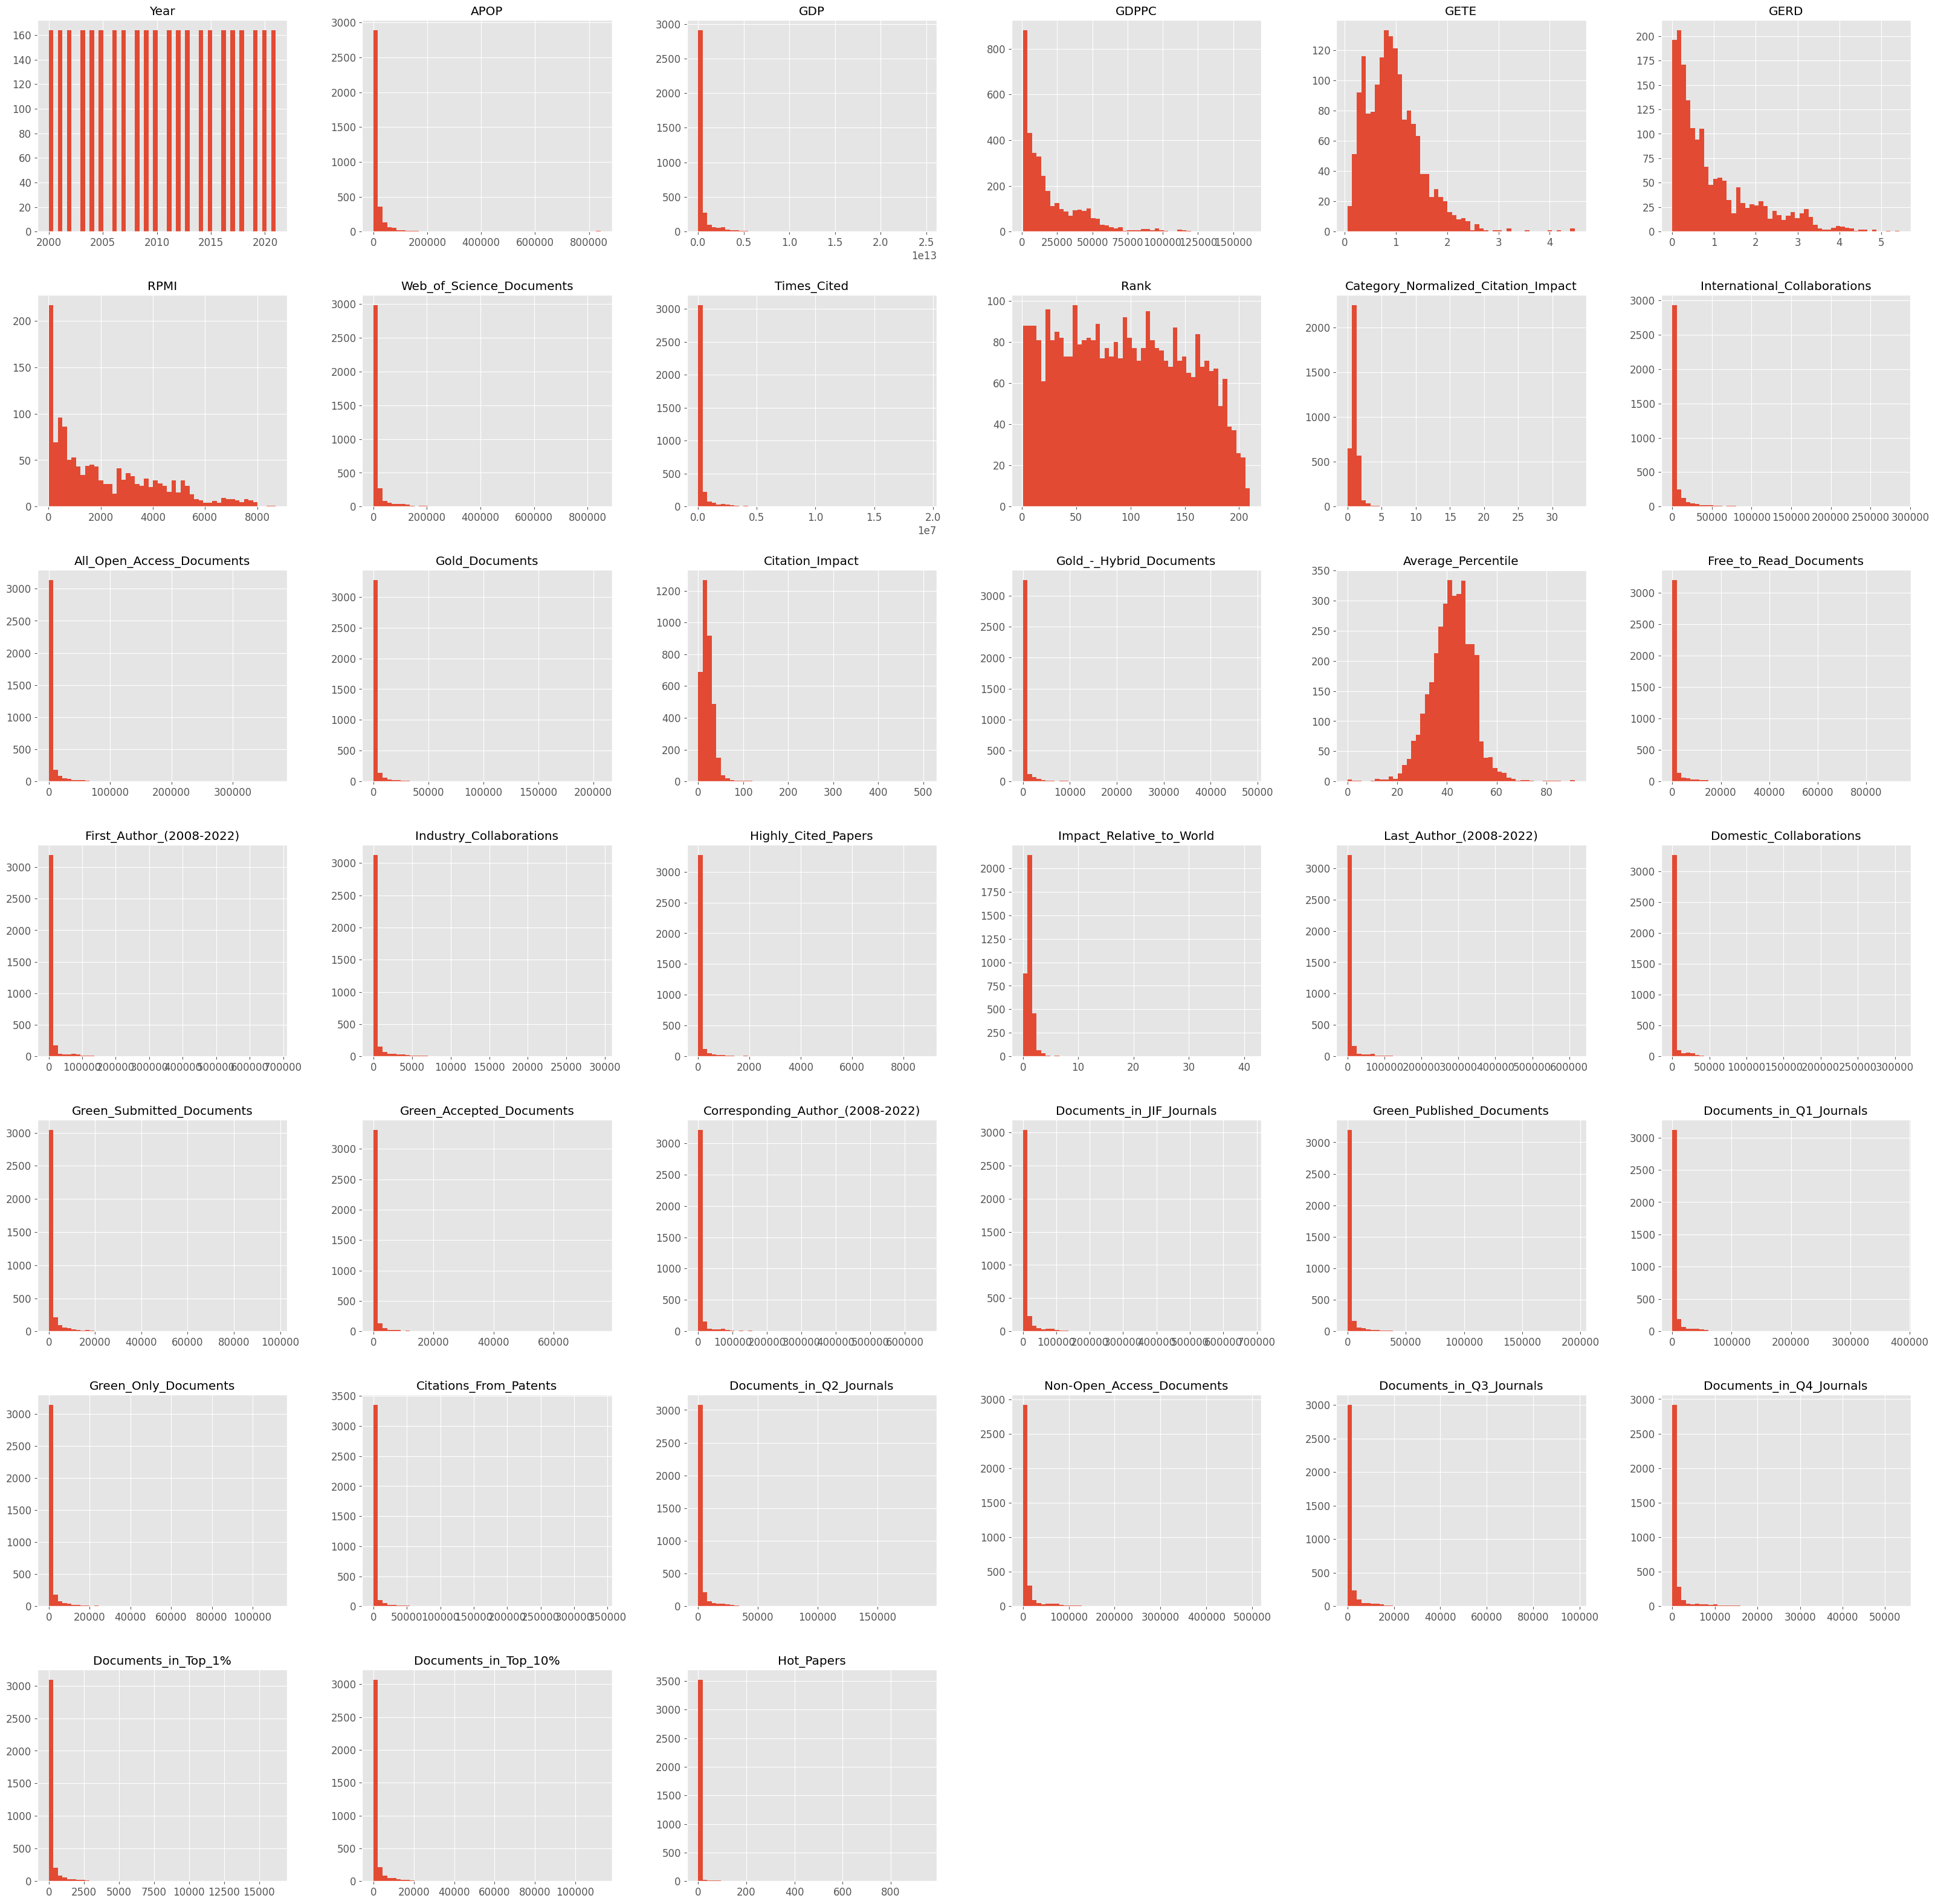

In [9]:
# Plot histograms for each variable, adjusting the number of bins
df.hist(bins=50, figsize=(40,40))
plt.show()

In [10]:
# Drop the column Rank, since the rank is not complete due to countries with missing values that were dropped
df = df.drop(['Rank'], axis=1)

### 6.2 Line Plot Insights

The line chart graphs can explain the evolution of the variables over time, comaparing Brazil to rest of the World. Most variables had a crescend trend, with some exceptions, such as those related to the number of citations. It is natural that the number of citations decreases over time, since the recent publications have less time to be cited.

The graphs also show that some of the variables do not present data for all the years, which is a problem for the analysis. Therefore, this variables were removed from the analysis.

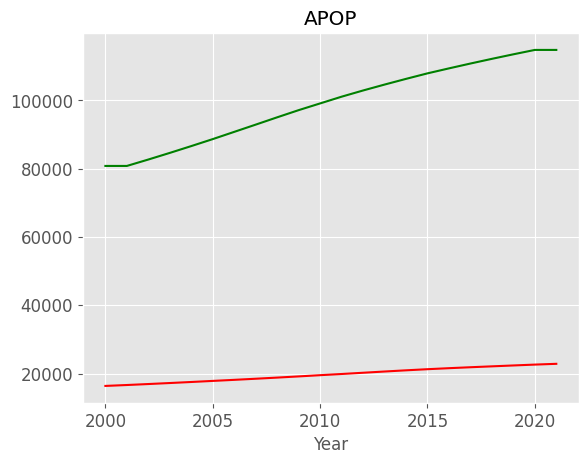

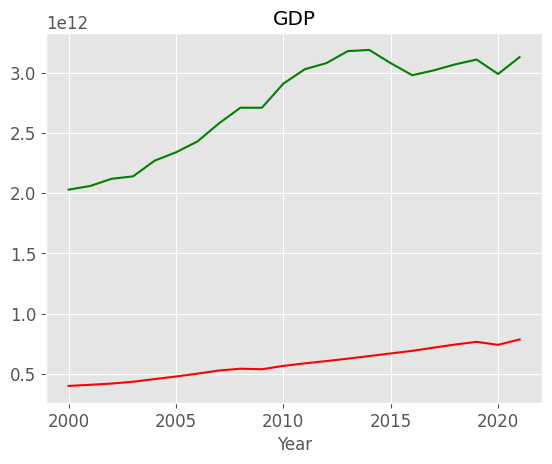

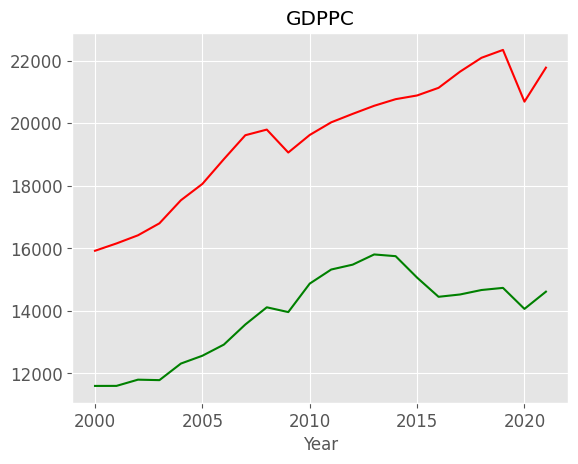

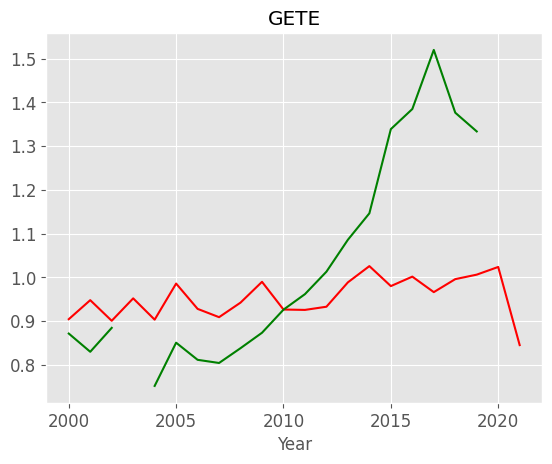

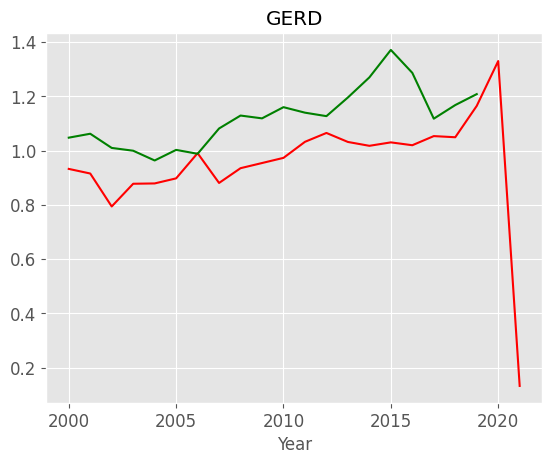

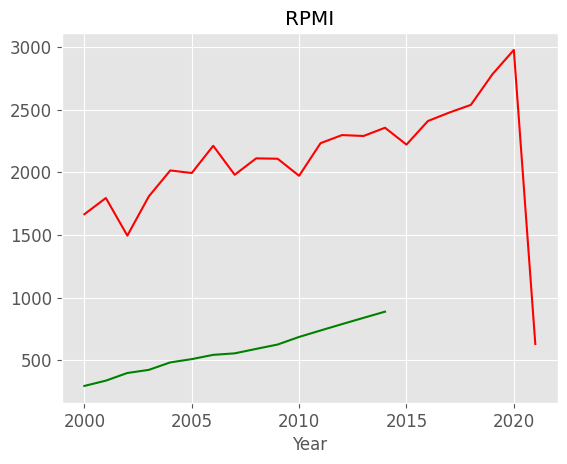

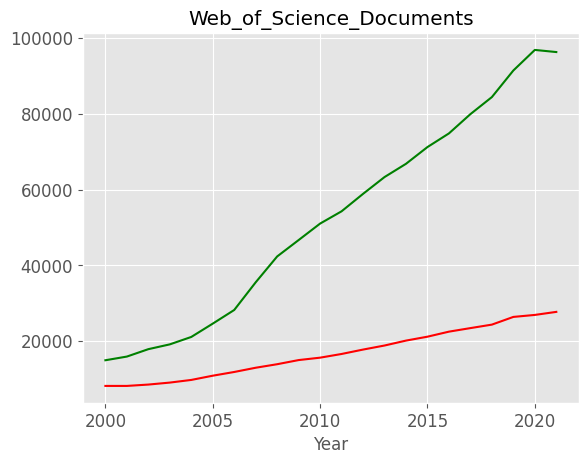

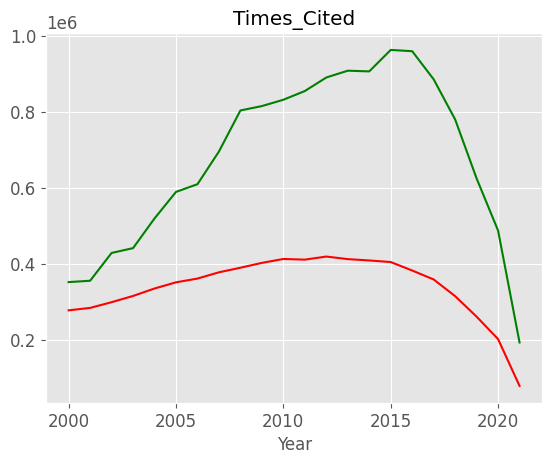

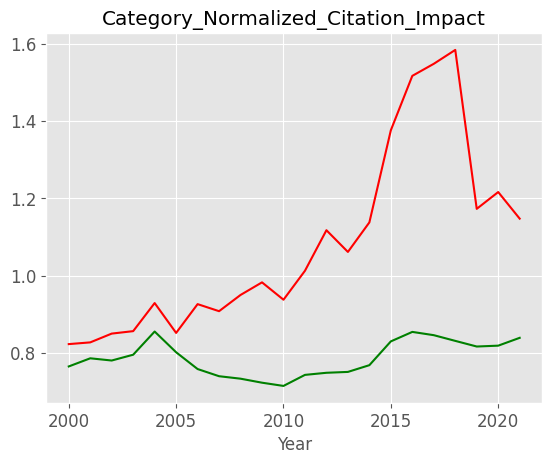

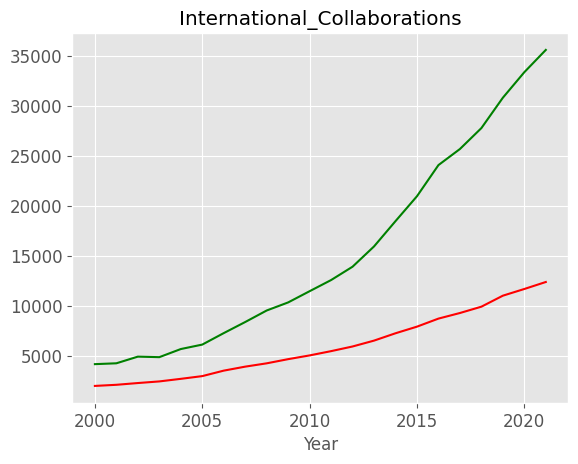

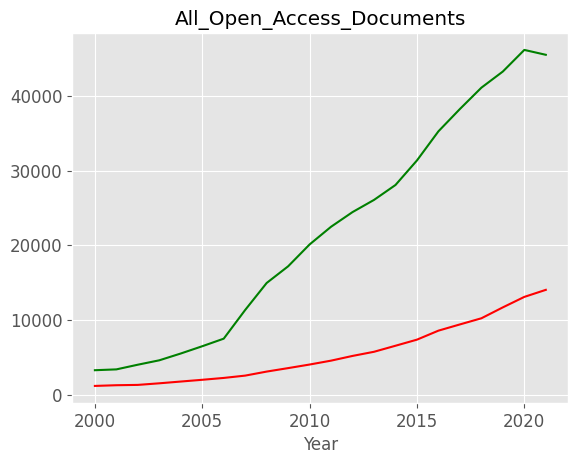

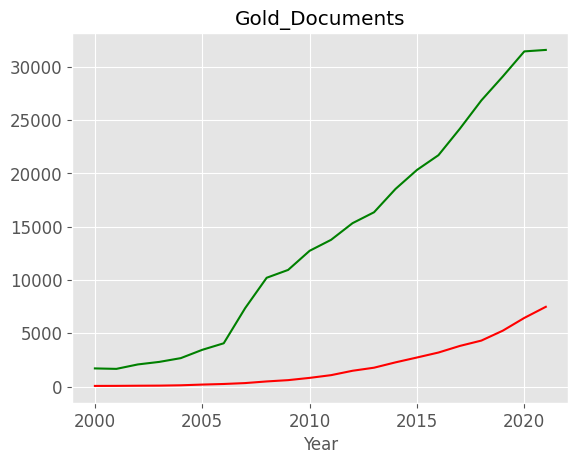

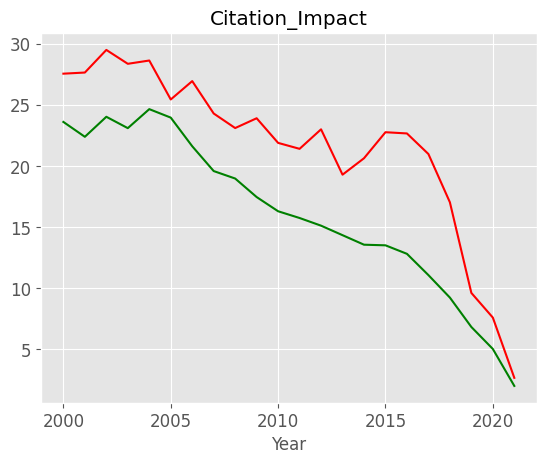

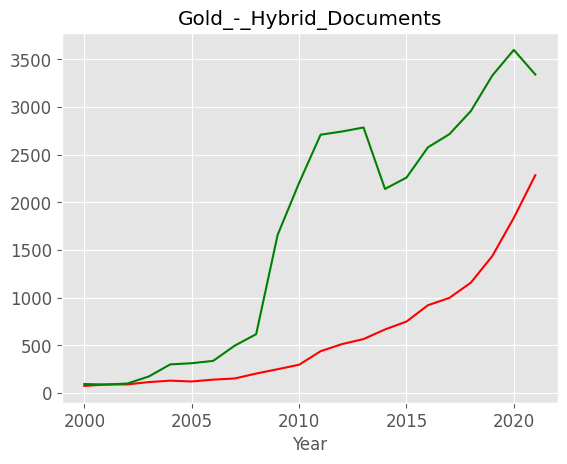

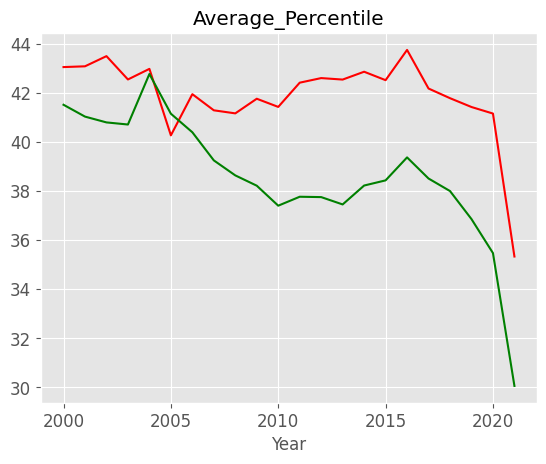

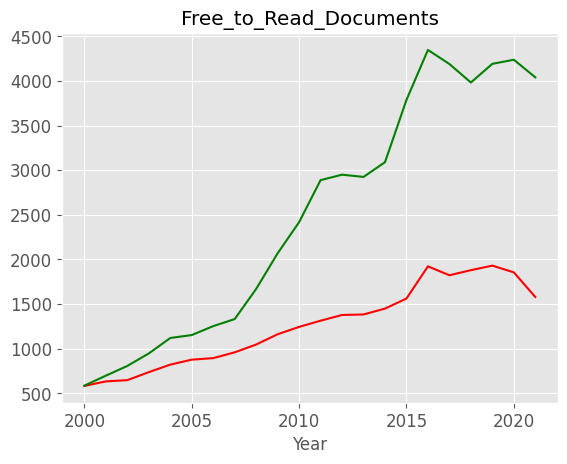

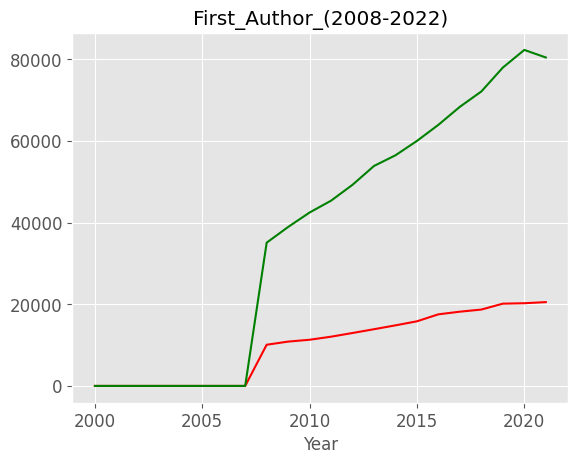

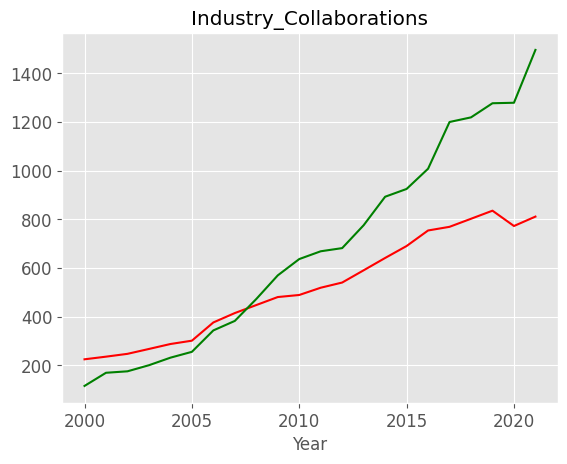

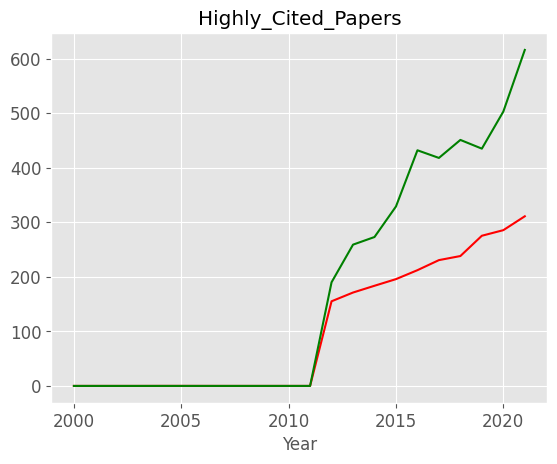

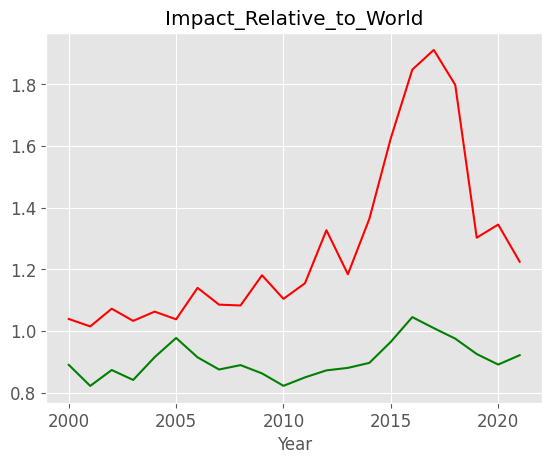

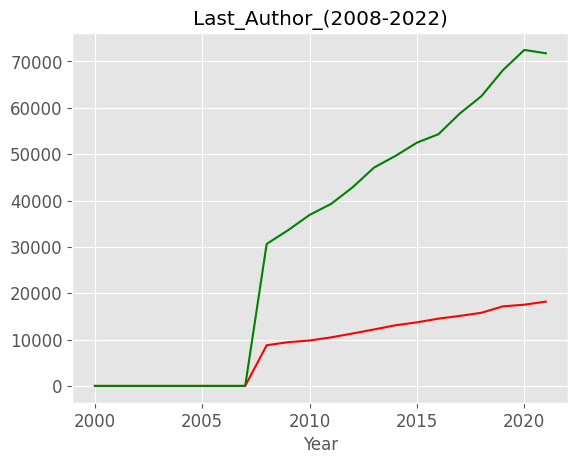

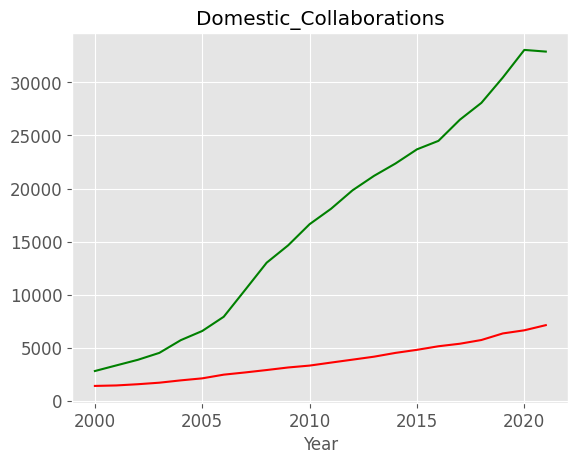

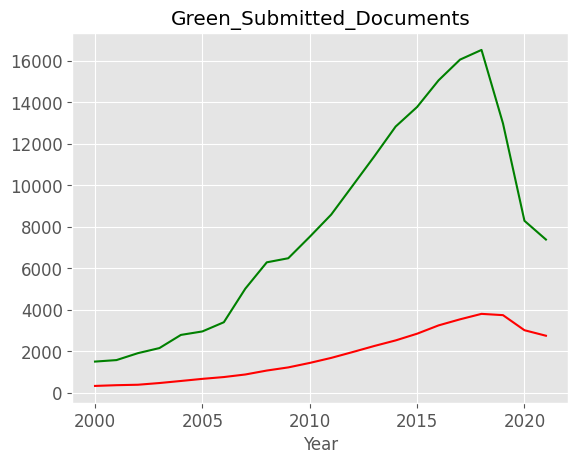

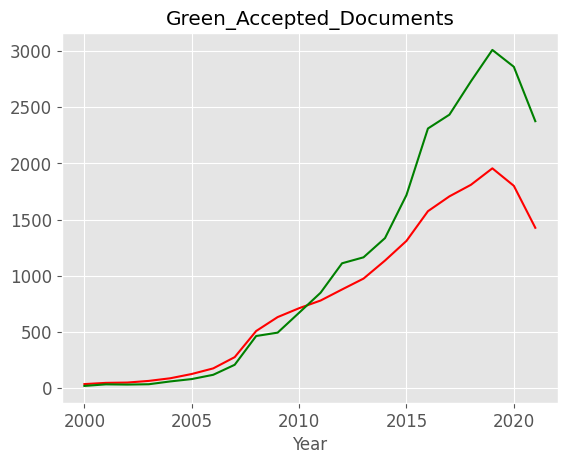

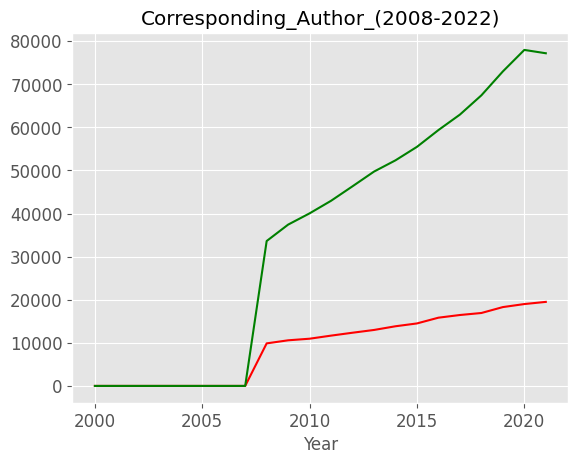

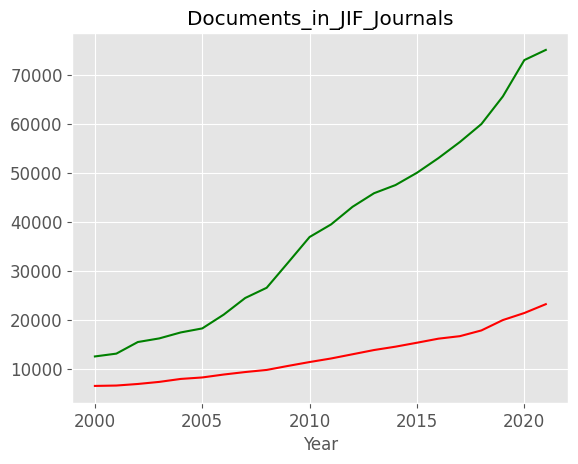

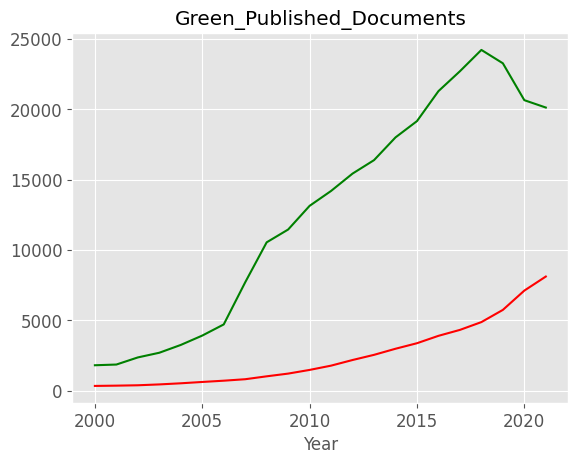

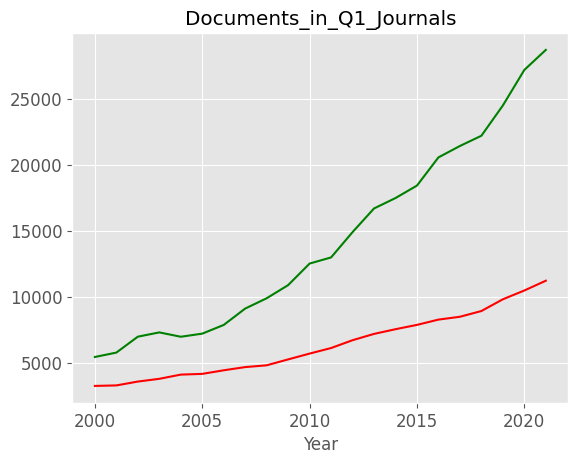

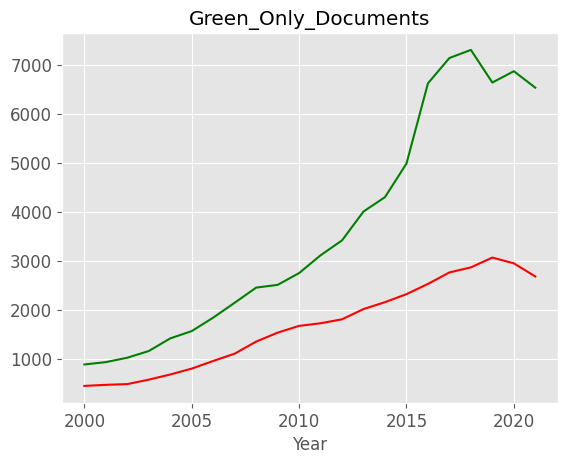

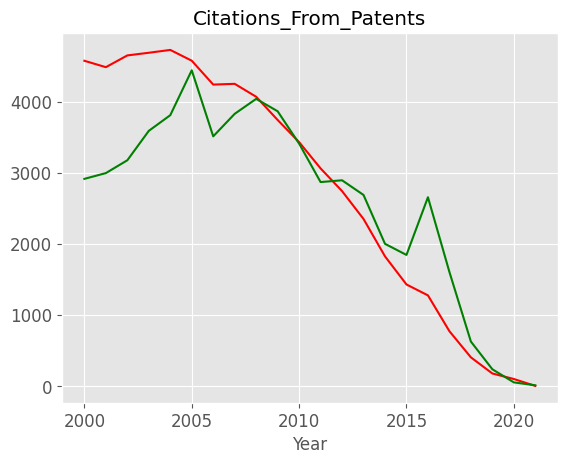

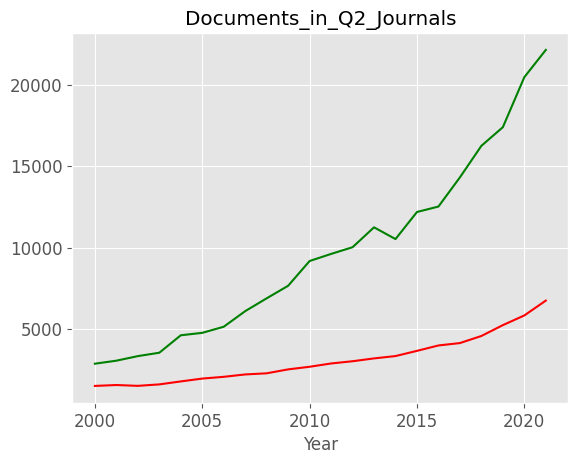

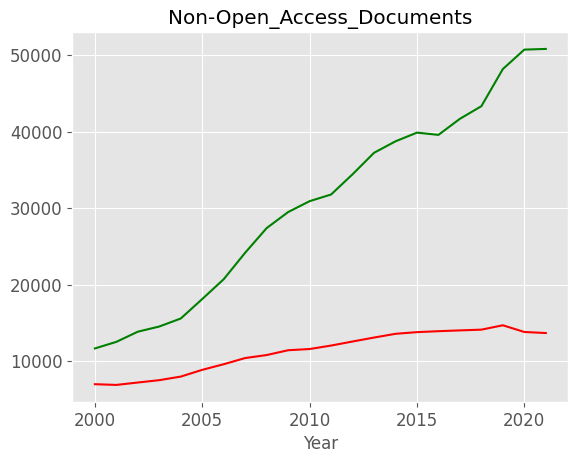

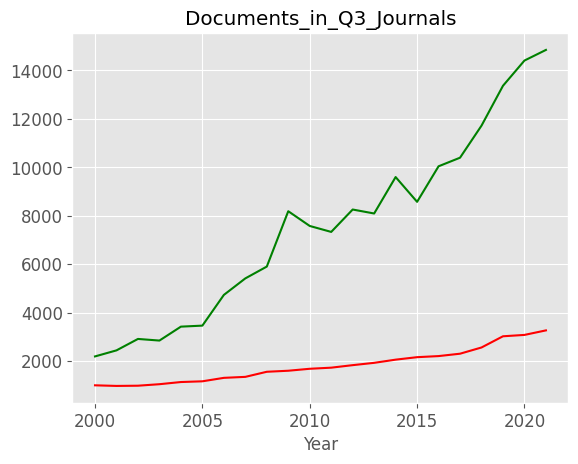

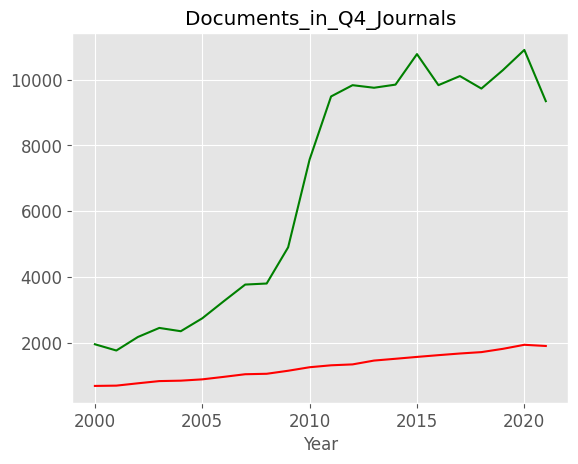

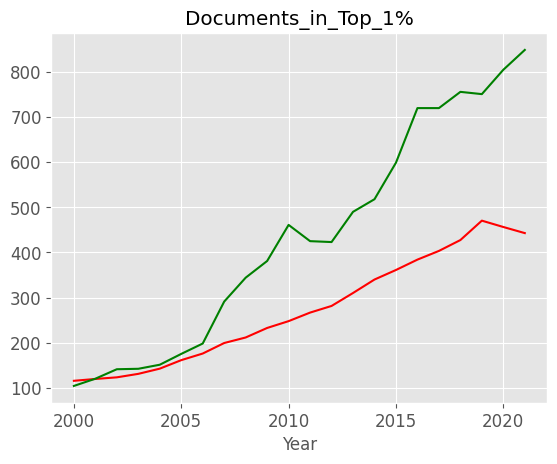

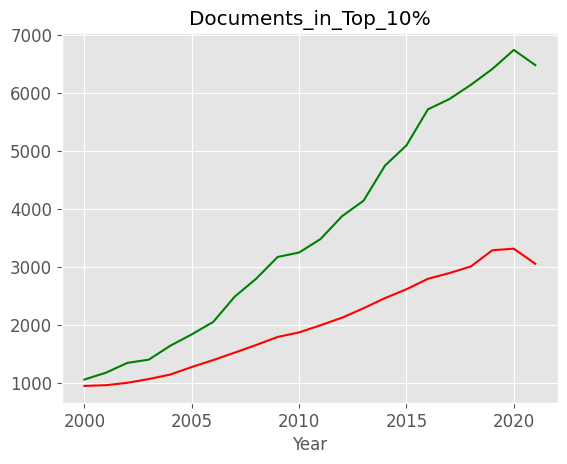

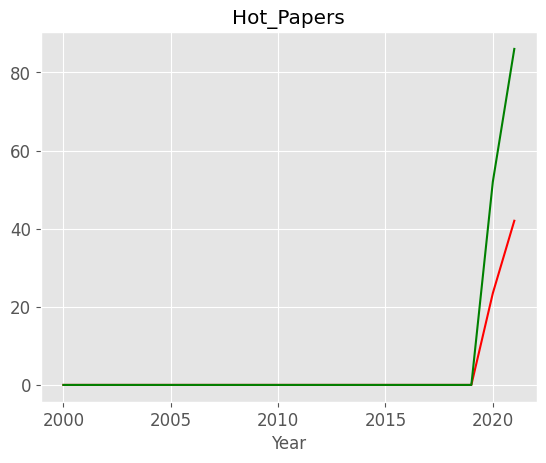

In [11]:
# For each variable after the 5th column, line chart with the valeu of Brazil (in green) vs the World average (in red)
for i in range(5, len(df.columns)):
    df.groupby('Year')[df.columns[i]].mean().plot(color = 'red')
    df[df['Country'] == 'Brazil'].groupby('Year')[df.columns[i]].mean().plot(color = 'green')
    plt.title(df.columns[i])
    plt.show()

In [12]:
# Drop the columns First Author (2008-2022), Last Author (2008-2022), Corresponding Author (2008-2022), Highly Cited Papers and Hot Papers, since they do not have a complete time series  
df = df.drop(['First_Author_(2008-2022)', 'Last_Author_(2008-2022)', 'Corresponding_Author_(2008-2022)', 'Highly_Cited_Papers', 'Hot_Papers'], axis=1)

### 6.3 Correlation Matrix Insights

The correlation matrix shows the correlation between the variables. The correlation between the variables is important to understand the relationship between them. Many of the variables are highly correlated, which is expected, since most of them are related to the scientific production.

In [13]:
# Plot a correlation matrix of 5h column onwards with heat map, with two decimal places
corr_matrix = df.iloc[:, 5:].corr()
corr_matrix.style.background_gradient(cmap='PuBuGn').set_precision(2)

,APOP,GDP,GDPPC,GETE,GERD,RPMI,Web_of_Science_Documents,Times_Cited,Category_Normalized_Citation_Impact,International_Collaborations,All_Open_Access_Documents,Gold_Documents,Citation_Impact,Gold_-_Hybrid_Documents,Average_Percentile,Free_to_Read_Documents,Industry_Collaborations,Impact_Relative_to_World,Domestic_Collaborations,Green_Submitted_Documents,Green_Accepted_Documents,Documents_in_JIF_Journals,Green_Published_Documents,Documents_in_Q1_Journals,Green_Only_Documents,Citations_From_Patents,Documents_in_Q2_Journals,Non-Open_Access_Documents,Documents_in_Q3_Journals,Documents_in_Q4_Journals,Documents_in_Top_1%,Documents_in_Top_10%
APOP,1.00,0.70,-0.05,0.02,0.10,-0.07,0.48,0.35,-0.04,0.36,0.38,0.47,-0.05,0.26,-0.04,0.31,0.31,-0.03,0.54,0.34,0.17,0.47,0.37,0.39,0.26,0.19,0.50,0.52,0.57,0.64,0.37,0.40
GDP,0.70,1.00,0.16,0.07,0.33,0.13,0.94,0.81,-0.01,0.82,0.83,0.75,-0.03,0.65,0.00,0.84,0.84,-0.01,0.95,0.79,0.62,0.93,0.78,0.89,0.76,0.60,0.93,0.95,0.95,0.96,0.87,0.89
GDPPC,-0.05,0.16,1.00,0.36,0.51,0.67,0.25,0.25,0.07,0.31,0.25,0.17,0.06,0.25,0.22,0.26,0.30,0.07,0.19,0.28,0.21,0.25,0.24,0.25,0.26,0.18,0.24,0.24,0.23,0.21,0.27,0.26
GETE,0.02,0.07,0.36,1.00,0.46,0.48,0.13,0.16,0.08,0.17,0.14,0.13,0.05,0.14,0.18,0.12,0.15,0.06,0.10,0.15,0.11,0.13,0.15,0.13,0.14,0.10,0.13,0.13,0.13,0.12,0.15,0.15
GERD,0.10,0.33,0.51,0.46,1.00,0.88,0.40,0.39,0.33,0.45,0.39,0.31,0.21,0.38,0.42,0.40,0.47,0.28,0.36,0.41,0.27,0.41,0.38,0.40,0.36,0.29,0.41,0.40,0.42,0.40,0.39,0.39
RPMI,-0.07,0.13,0.67,0.48,0.88,1.00,0.25,0.24,0.42,0.34,0.27,0.19,0.19,0.30,0.45,0.27,0.34,0.38,0.19,0.30,0.21,0.25,0.27,0.26,0.27,0.17,0.25,0.23,0.24,0.21,0.26,0.26
Web_of_Science_Documents,0.48,0.94,0.25,0.13,0.40,0.25,1.00,0.87,0.03,0.95,0.95,0.80,-0.02,0.79,0.06,0.96,0.96,0.01,0.97,0.92,0.80,1.00,0.90,0.99,0.92,0.62,0.99,0.99,0.98,0.92,0.98,0.99
Times_Cited,0.35,0.81,0.25,0.16,0.39,0.24,0.87,1.00,0.03,0.75,0.70,0.42,0.06,0.52,0.09,0.85,0.85,0.02,0.78,0.71,0.64,0.85,0.60,0.87,0.78,0.89,0.79,0.92,0.80,0.77,0.88,0.89
Category_Normalized_Citation_Impact,-0.04,-0.01,0.07,0.08,0.33,0.42,0.03,0.03,1.00,0.04,0.03,0.02,0.76,0.04,0.32,0.03,0.04,0.96,0.01,0.04,0.04,0.03,0.04,0.03,0.04,0.02,0.03,0.02,0.02,-0.00,0.04,0.04
International_Collaborations,0.36,0.82,0.31,0.17,0.45,0.34,0.95,0.75,0.04,1.00,0.98,0.82,-0.04,0.90,0.08,0.94,0.95,0.03,0.89,0.97,0.86,0.95,0.95,0.94,0.95,0.45,0.95,0.89,0.91,0.85,0.95,0.95


## 7 Adjusting the Data for the Analysis

In [14]:
# Create a new dataframe named "dfs", scaling the data on each column of "df" between the 5th and the last three, keeping the first 5 columns (rounding to 2 decimal places)
# dfs = df.iloc[:, 5:].apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0).round(4)
# dfs = pd.concat([df.iloc[:, :5], dfs], axis=1)
dfs = df

# Create a new column in the first position, with a numeric ID for each , starting from 1
dfs['ID'] = dfs.groupby('Country').ngroup()+1

# Drop Year > 2016
dfs = dfs[dfs['Year'] >= 2007]

# Create column "treated", with "True" for Brazil  and "False" for the rest of the countries
dfs['treated'] = np.where(dfs['Country'] == 'Brazil', True, False)

# Create column "after_treatment", with "True" for years between 2006 and 2016, and "False" for the rest of the years
dfs['after_treatment'] = np.where((dfs['Year'] >= 2007) & (dfs['Year'] <= 2016), True, False)

# Print first 50 rows of the dataset
dfs.head(20)

# Print Brazil's data
dfs[dfs['Country'] == 'Brazil']

,Country,Code,Region,Income_Group,Year,APOP,GDP,GDPPC,GETE,GERD,RPMI,Web_of_Science_Documents,Times_Cited,Category_Normalized_Citation_Impact,International_Collaborations,All_Open_Access_Documents,Gold_Documents,Citation_Impact,Gold_-_Hybrid_Documents,Average_Percentile,Free_to_Read_Documents,Industry_Collaborations,Impact_Relative_to_World,Domestic_Collaborations,Green_Submitted_Documents,Green_Accepted_Documents,Documents_in_JIF_Journals,Green_Published_Documents,Documents_in_Q1_Journals,Green_Only_Documents,Citations_From_Patents,Documents_in_Q2_Journals,Non-Open_Access_Documents,Documents_in_Q3_Journals,Documents_in_Q4_Journals,Documents_in_Top_1%,Documents_in_Top_10%,ID,treated,after_treatment
1516,Brazil,BRA,Latin America & Caribbean,Upper middle income,2007,92901.0,2.580000e+12,13565.0,0.80442,1.08138,555.12941,35524.0,696612.0,0.739125,8391.0,11333.0,7358.0,19.609616,496.0,39.252170,1332.0,383.0,0.875364,10468.0,5019.0,208.0,24405.0,7709.0,9127.0,2147.0,3827.0,6094.0,24191.0,5411.0,3773.0,291.0,2486.0,21,True,True
1729,Brazil,BRA,Latin America & Caribbean,Upper middle income,2008,95042.0,2.710000e+12,14115.0,0.83828,1.12904,590.71388,42351.0,804578.0,0.732731,9544.0,14944.0,10201.0,18.997851,617.0,38.640528,1670.0,473.0,0.889573,13025.0,6288.0,464.0,26492.0,10551.0,9906.0,2456.0,4037.0,6882.0,27407.0,5899.0,3805.0,344.0,2796.0,21,True,True
1942,Brazil,BRA,Latin America & Caribbean,Upper middle income,2009,97142.0,2.710000e+12,13962.0,0.87355,1.11866,625.52058,46681.0,816084.0,0.722340,10353.0,17177.0,10937.0,17.482145,1659.0,38.220672,2069.0,570.0,0.862713,14657.0,6485.0,494.0,31644.0,11461.0,10900.0,2512.0,3863.0,7653.0,29504.0,8186.0,4905.0,381.0,3171.0,21,True,True
2155,Brazil,BRA,Latin America & Caribbean,Upper middle income,2010,99112.0,2.910000e+12,14873.0,0.92630,1.15992,686.12491,51031.0,832740.0,0.713979,11476.0,20105.0,12729.0,16.318316,2205.0,37.405939,2418.0,637.0,0.822427,16650.0,7518.0,671.0,36855.0,13145.0,12531.0,2753.0,3409.0,9175.0,30926.0,7577.0,7572.0,461.0,3248.0,21,True,True
2368,Brazil,BRA,Latin America & Caribbean,Upper middle income,2011,101082.0,3.030000e+12,15323.0,0.96178,1.13966,737.71786,54273.0,855657.0,0.742582,12591.0,22475.0,13760.0,15.765795,2710.0,37.770314,2889.0,669.0,0.849764,18103.0,8589.0,849.0,39423.0,14204.0,12995.0,3116.0,2869.0,9610.0,31798.0,7331.0,9487.0,425.0,3481.0,21,True,True
2581,Brazil,BRA,Latin America & Caribbean,Upper middle income,2012,102899.0,3.080000e+12,15479.0,1.01311,1.12684,788.48979,58880.0,891311.0,0.748021,13928.0,24438.0,15323.0,15.137755,2744.0,37.755790,2950.0,682.0,0.872535,19840.0,9985.0,1111.0,43017.0,15437.0,14910.0,3421.0,2894.0,10022.0,34442.0,8256.0,9829.0,423.0,3875.0,21,True,True
2794,Brazil,BRA,Latin America & Caribbean,Upper middle income,2013,104630.0,3.180000e+12,15805.0,1.08613,1.19567,838.47208,63315.0,909166.0,0.750283,15958.0,26067.0,16345.0,14.359409,2786.0,37.456668,2925.0,776.0,0.880605,21199.0,11384.0,1164.0,45786.0,16393.0,16699.0,4011.0,2688.0,11244.0,37248.0,8092.0,9751.0,490.0,4141.0,21,True,True
3007,Brazil,BRA,Latin America & Caribbean,Upper middle income,2014,106300.0,3.190000e+12,15750.0,1.14653,1.26971,887.67844,66816.0,907329.0,0.767736,18489.0,28066.0,18531.0,13.579517,2141.0,38.226978,3090.0,893.0,0.896894,22363.0,12831.0,1335.0,47452.0,18009.0,17486.0,4304.0,2002.0,10523.0,38750.0,9597.0,9846.0,518.0,4748.0,21,True,True
3220,Brazil,BRA,Latin America & Caribbean,Upper middle income,2015,107917.0,3.080000e+12,15064.0,1.33896,1.37093,NaN,71241.0,963822.0,0.829390,20982.0,31354.0,20316.0,13.529035,2260.0,38.437789,3788.0,925.0,0.965291,23696.0,13774.0,1718.0,49962.0,19167.0,18429.0,4990.0,1846.0,12186.0,39887.0,8574.0,10773.0,599.0,5097.0,21,True,True
3433,Brazil,BRA,Latin America & Caribbean,Upper middle income,2016,109375.0,2.980000e+12,14451.0,1.38490,1.28637,NaN,74845.0,960467.0,0.853941,24099.0,35253.0,21699.0,12.832748,2578.0,39.373655,4348.0,1008.0,1.045312,24494.0,15058.0,2310.0,52955.0,21297.0,20561.0,6628.0,265

If we want to go from this table to the matrix representation we discussed earlier, all we have to do is pivot the table by time (year) and unit (Country). We'll be going back and forth between these two representations, as one is more convenient for DiD and the other, for Synthetic Controls estimation. 

In [15]:
dfs_piv = dfs.pivot("Year", "Country", "Web_of_Science_Documents")
dfs_piv = dfs_piv.rename(columns={c: f"{c}" for c in dfs_piv.columns if c != "Brazil"})

dfs_piv.head(17).round(4)

Country,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bermuda,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burundi,Cambodia,Cameroon,Canada,Central African Republic,Chad,...,Slovenia,Solomon Islands,South Africa,Spain,Sri Lanka,St. Kitts and Nevis,Sudan,Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Tanzania,Thailand,The Bahamas,The Gambia,Togo,Trinidad and Tobago,Tunisia,Turkey,Uganda,Ukraine,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Vietnam,Zambia,Zimbabwe
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007,127.0,1824.0,21.0,9.0,8627.0,649.0,54153.0,16938.0,398.0,213.0,1104.0,81.0,1614.0,22921.0,11.0,164.0,39.0,248.0,536.0,310.0,35524.0,65.0,3480.0,215.0,19.0,139.0,569.0,82364.0,24.0,14.0,...,4018.0,16.0,10444.0,61395.0,610.0,19.0,273.0,10.0,29.0,26375.0,29790.0,56.0,630.0,5888.0,25.0,99.0,54.0,268.0,2740.0,27452.0,624.0,7592.0,159436.0,569274.0,745.0,504.0,14.0,1048.0,198.0,356.0
2008,143.0,2240.0,25.0,12.0,10116.0,812.0,59908.0,18195.0,463.0,217.0,1559.0,107.0,1544.0,24316.0,13.0,208.0,33.0,299.0,640.0,320.0,42351.0,84.0,3562.0,255.0,11.0,156.0,650.0,87489.0,24.0,14.0,...,4604.0,8.0,11349.0,66444.0,760.0,32.0,316.0,11.0,26.0,27137.0,31361.0,69.0,639.0,7589.0,19.0,133.0,53.0,269.0,3247.0,28584.0,647.0,7993.0,163526.0,587772.0,884.0,499.0,14.0,1405.0,228.0,315.0
2009,214.0,2574.0,48.0,6.0,10730.0,757.0,66064.0,19616.0,591.0,274.0,1514.0,102.0,1658.0,26199.0,13.0,240.0,34.0,284.0,739.0,299.0,46681.0,109.0,4066.0,308.0,14.0,179.0,724.0,92091.0,28.0,24.0,...,4726.0,11.0,12512.0,74296.0,855.0,27.0,382.0,9.0,40.0,28714.0,34310.0,55.0,762.0,8150.0,25.0,107.0,61.0,329.0,3919.0,32514.0,809.0,8034.0,173264.0,617409.0,980.0,533.0,21.0,1571.0,235.0,310.0
2010,300.0,2483.0,43.0,7.0,11966.0,908.0,68839.0,20809.0,736.0,270.0,1779.0,116.0,1628.0,27772.0,35.0,268.0,34.0,296.0,874.0,282.0,51031.0,120.0,3675.0,301.0,33.0,192.0,777.0,94544.0,31.0,12.0,...,4887.0,25.0,13291.0,79722.0,801.0,29.0,443.0,12.0,67.0,30460.0,36169.0,83.0,848.0,8756.0,31.0,144.0,70.0,319.0,4027.0,34541.0,1036.0,7859.0,179569.0,630889.0,1154.0,531.0,20.0,1822.0,277.0,352.0
2011,331.0,2837.0,42.0,7.0,12590.0,1013.0,75511.0,21783.0,769.0,302.0,2001.0,168.0,1660.0,29375.0,19.0,302.0,47.0,324.0,910.0,365.0,54273.0,112.0,3552.0,360.0,29.0,214.0,792.0,97593.0,38.0,23.0,...,5401.0,21.0,15178.0,84302.0,827.0,21.0,469.0,10.0,68.0,31973.0,38252.0,103.0,915.0,8996.0,30.0,100.0,90.0,326.0,4345.0,36094.0,1019.0,8616.0,189011.0,652087.0,1243.0,592.0,32.0,1932.0,310.0,371.0
2012,368.0,3581.0,53.0,9.0,13446.0,1130.0,81701.0,22721.0,921.0,313.0,2650.0,140.0,1866.0,30585.0,24.0,315.0,45.0,298.0,877.0,362.0,58880.0,153.0,4170.0,405.0,28.0,265.0,867.0,102069.0,41.0,24.0,...,5556.0,15.0,17282.0,89364.0,1028.0,49.0,513.0,26.0,57.0,35098.0,40438.0,97.0,900.0,10609.0,35.0,133.0,80.0,299.0,4792.0,39616.0,1133.0,9169.0,196693.0,682245.0,1295.0,547.0,26.0,2565.0,373.0,467.0
2013,430.0,4175.0,60.0,14.0,14194.0,1072.0,90931.0,23818.0,719.0,403.0,2883.0,139.0,1866.0,32463.0,35.0,402.0,48.0,333.0,857.0,395.0,63315.0,177.0,4316.0,412.0,56.0,287.0,1032.0,106281.0,41.0,26.0,...,5800.0,20.0,18154.0,93233.0,1240.0,44.0,662.0,34.0,74.0,36735.0,42650.0,104.0,1106.0,10853.0,47.0,161.0,93.0,306.0,5586.0,43486.0,1328.0,9870.0,208109.0,702046.0,1361.0,534.0,30.0,3437.0,423.0,491.0
2014,483.0,4778.0,84.0,9.0,14775.0,1085.0,97544.0,25709.0,742.0,423.0,3477.0,137.0,1923.0,34458.0,24.0,390.0,43.0,335.0,899.0,502.0,66816.0,277.0,4441.0,421.0,45.0,299.0,1176.0,112088.0,45.0,32.0,...,5933.0,29.0,19909.0,97274.0,1296.0,105.0,616.0,22.0,52.0,39760.0,45921.0,86.0,1286.0,12131.0,59.0,186.0,124.0,457.0,6301.0,45612.0,1406.0,10667.0,212777.0,733193.0,1635.0,589.0,33.0,3836.0,450.0,642.0
2015,606.0,5496.0,117.0,17.0,15697.0,1171.0,104609.0,26652.0,837.0,405.0,3923.0,161.0,1869.0,36043.0,37.0,469.0,54.0,392.0,1126.0,430.0,71241.0,359.0,4447.0,601.0,59.0,403.0,12

## Application of the SDID Method
Ideally, this should be calculated here in Python and my hope is to be able to make it work. However for this assingnment I was not able to do it. I have done the calculations of the results presented in the draft of the paper using Stata, and the DoFiles used to code the algorithm will be shared on GitHub.